In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import os

In [2]:
# TODO input from console for test, change index averaging, fix fluctuation and input data

# Read env variables
# data_path = os.getenv('DATA_FILE')
# data_sensor = os.getenv('DATA_SENSOR')
# supervised_mode = os.getenv('SUPERVISED_MODE')
# target_rec_loss = float(os.getenv('TARGET_REC_LOSS'))
# seq_size = int(os.getenv('SEQ_SIZE'))
# factor = int(os.getenv('FACTOR'))

# Hardcoded for now
# data_path = input('Data Path:')
# data_sensor = input('Data Sensor:')
# supervised_mode = bool(input('Supervised Mode(True/False):'))
# seq_size = int(input('Sequence Size:'))
# offset = int(input('Prediction Offset:'))
# factor = int(input('Factor for threshold calculation:'))


data_path = 'all_data/fl_data.csv'
data_sensor = 'dms1'
supervised_mode = True
threshold = 0
seq_size = 100
factor = 3
sensors = 8
offset = 10

dataframe = pd.read_csv(data_path, delimiter=';')
df = dataframe[['counter', 'dms1', 'dms2', 'dms3', 'dms4', 'dms5', 'dms6', 'dms7', 'dms8']]

df = df.groupby(df.index // 10).agg({
    'counter': 'first',
    'dms1': 'mean',
    'dms2': 'mean',
    'dms3': 'mean',
    'dms4': 'mean',
    'dms5': 'mean',
    'dms6': 'mean',
    'dms7': 'mean',
    'dms8': 'mean'
}).reset_index(drop=True)

# df = df.iloc[1800:-1200]


print("Start: ", df['counter'].min())
print("End: ", df['counter'].max())

print(f"Shape of df after slicing: {df.shape}")

# approx 80/20 split
train_test_ratio = 0.8
breakpoint = int(len(df) * train_test_ratio)
train, test = df.iloc[:breakpoint], df.iloc[breakpoint:]

print(train.shape)

scaler = StandardScaler()
dms_sensors = [f"dms{i}" for i in range(1, sensors + 1)]
scaler = scaler.fit(train[dms_sensors])

train[dms_sensors] = scaler.transform(train[dms_sensors])
test[dms_sensors] = scaler.transform(test[dms_sensors])

def to_sequences(x, seq_size=1):
    x_values = []
    y_values = []
    print('lenx: ', len(x))

    for i in range(len(x) - seq_size - offset):
        x_values.append(x.iloc[i:(i + seq_size)].values)
        y_values.append(x.iloc[i + offset:(i + offset + seq_size)].values)
    return np.array(x_values), np.array(y_values)

num_train_sequences = len(train) - seq_size
num_test_sequences = len(test) - seq_size

# shape: (samples, seq_size, n_features)
# shape: (samples, seq_size, n_features)
trainX, trainY = [], []
testX, testY = [], []

for sensor in dms_sensors:
    trainX_tmp, trainY_tmp = to_sequences(train[sensor], seq_size)
    testX_tmp, testY_tmp = to_sequences(test[sensor], seq_size)
    trainX.append(trainX_tmp)
    trainY.append(trainY_tmp)
    testX.append(testX_tmp)
    testY.append(testY_tmp)

trainX = np.concatenate(trainX, axis=0).reshape(-1, seq_size, sensors)
trainY = np.concatenate(trainY, axis=0).reshape(-1, seq_size, sensors)
testX = np.concatenate(testX, axis=0).reshape(-1, seq_size, sensors)
testY = np.concatenate(testY, axis=0).reshape(-1, seq_size, sensors)

print('trainX shape:', trainX.shape)
print('trainY shape:', trainY.shape)
print('testX shape:', testX.shape)
print('testY shape:', testY.shape)

print(f"Number of train sequences: {num_train_sequences}")
print(f"Number of test sequences: {num_test_sequences}")


# print(trainX.shape)
# print(trainY.shape)

trainX = torch.tensor(trainX, dtype=torch.float32)
trainY = torch.tensor(trainY, dtype=torch.float32)
testX = torch.tensor(testX, dtype=torch.float32)
testY = torch.tensor(testY, dtype=torch.float32)

train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

Start:  0
End:  223070
Shape of df after slicing: (22308, 9)
(17846, 9)
lenx:  17846


/tmp/ipykernel_2654019/643921261.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[dms_sensors] = scaler.transform(train[dms_sensors])
/tmp/ipykernel_2654019/643921261.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[dms_sensors] = scaler.transform(test[dms_sensors])


lenx:  4462
lenx:  17846
lenx:  4462
lenx:  17846
lenx:  4462
lenx:  17846
lenx:  4462
lenx:  17846
lenx:  4462
lenx:  17846
lenx:  4462
lenx:  17846
lenx:  4462
lenx:  17846
lenx:  4462
trainX shape: (17736, 100, 8)
trainY shape: (17736, 100, 8)
testX shape: (4352, 100, 8)
testY shape: (4352, 100, 8)
Number of train sequences: 17746
Number of test sequences: 4362


In [3]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.lstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.lstm2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=2,
            # dropout=0.5,
            batch_first=True
        )

    def forward(self, x):
        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=128, n_features=3):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.lstm1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=2,
            # dropout=0.5,
            batch_first=True
        )

        self.lstm2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.dense_layers = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = self.dense_layers(x)
        return x

class LSTMAutoencoder(nn.Module):
    def __init__(self, device, seq_len, n_features, embedding_dim=128):
        super(LSTMAutoencoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # print(x.shape)
        return x

In [4]:
def train(device, model, train_dl, n_epochs=100):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    epoch_losses = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X, Y in train_dl:
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dl)
        epoch_losses.append(train_loss)
        print(f'Epoch {epoch+1}, Loss: {train_loss}')

    # training loss
    epochs = range(1, n_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, epoch_losses, marker='o', label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()


def detect(model, test_dl, device, supervised_mode=False):
    model.eval()
    criterion = nn.MSELoss()
    reconstruction_errors = []
    actual_data = []
    pred_data = []

    with torch.no_grad():
        for x, y in test_dl:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            # print("out: ", output.shape)
            # print("y: ", y.shape)
            loss = criterion(output, y)
            reconstruction_error = loss.item()
            reconstruction_errors.append(reconstruction_error)

            actual_data.append(y.cpu().numpy())
            pred_data.append(output.cpu().numpy())

    actual_data = np.concatenate(actual_data, axis=0)
    pred_data = np.concatenate(pred_data, axis=0)
    counter = np.arange(1, actual_data.shape[0] + 1)

    # print("ad: ", actual_data.shape)
    # print("pd: ", pred_data.shape)

    actual_data = actual_data[-50:]
    pred_data = pred_data[-50:]

    x = np.arange(1, len(reconstruction_errors) + 1)

    plt.hist(reconstruction_errors, bins=50, color='blue')

    plt.figure(figsize=(14, 7))
    sns.lineplot(x=x, y=reconstruction_errors, color='blue', label=f'Reconstruction Error')
    plt.xlabel('Sequence')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.show()

    # seq along the time axis
    actual_data_concat = actual_data.reshape(-1, actual_data.shape[2])
    pred_data_concat = pred_data.reshape(-1, pred_data.shape[2])

    counter = np.arange(actual_data_concat.shape[0])

    for feature in range(actual_data.shape[2]):
        plt.figure(figsize=(15, 6))
        plt.plot(counter, actual_data_concat[:, feature], color='green', alpha=1)
        plt.plot(counter, pred_data_concat[:, feature], color='red', alpha=0.6)
        plt.title(f'Feature {feature + 1} - All Sequences')
        plt.xlabel('Time step')
        plt.ylabel('Value')
        plt.legend(['Actual', 'Predicted'], loc='upper right')
        plt.show()

    # threshold = upper bound for 90% confidence interval
    if supervised_mode:
        mean_error = np.mean(reconstruction_errors)
        std_error = np.std(reconstruction_errors)
        upper_bound = mean_error + 1.645 * std_error
        os.environ['threshold'] = str(upper_bound)
        return upper_bound
    else:
        anomalies = []
        for err in reconstruction_errors:
            if err > threshold:
                anomalies.append(err)
        return len(anomalies)


Epoch 1, Loss: 0.5056401285972144
Epoch 2, Loss: 0.3128203502109459
Epoch 3, Loss: 0.29251306812773953
Epoch 4, Loss: 0.24813673738222403
Epoch 5, Loss: 0.2202834004452368
Epoch 6, Loss: 0.20756309101576204
Epoch 7, Loss: 0.1987528725384592
Epoch 8, Loss: 0.18836338906842579
Epoch 9, Loss: 0.18032468313032443
Epoch 10, Loss: 0.172465185267297
Epoch 11, Loss: 0.16672001188906194
Epoch 12, Loss: 0.16035165343232252
Epoch 13, Loss: 0.15405464610168795
Epoch 14, Loss: 0.1472391679681636
Epoch 15, Loss: 0.14063982217161505
Epoch 16, Loss: 0.13580254056902083
Epoch 17, Loss: 0.13039419723020212
Epoch 18, Loss: 0.1255715108241651
Epoch 19, Loss: 0.12189745513286006
Epoch 20, Loss: 0.11813084741315998
Epoch 21, Loss: 0.11602571642043086
Epoch 22, Loss: 0.11222626328938179
Epoch 23, Loss: 0.10900540186998409
Epoch 24, Loss: 0.10611738301729699
Epoch 25, Loss: 0.10379732672527835
Epoch 26, Loss: 0.10156012151373534
Epoch 27, Loss: 0.09983375152103133
Epoch 28, Loss: 0.09722927968596687
Epoch 29,

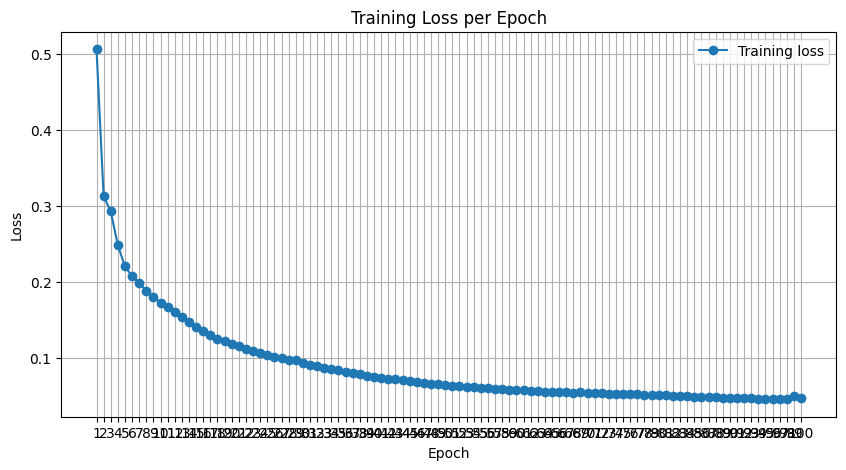

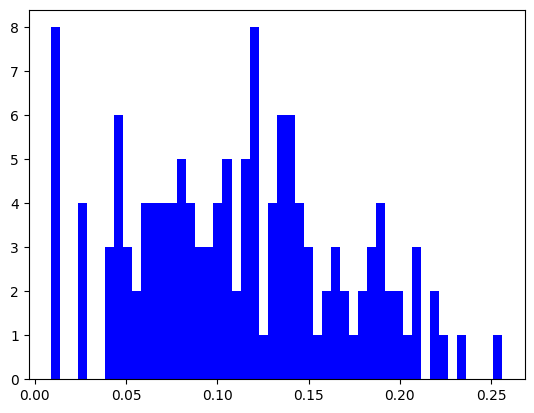

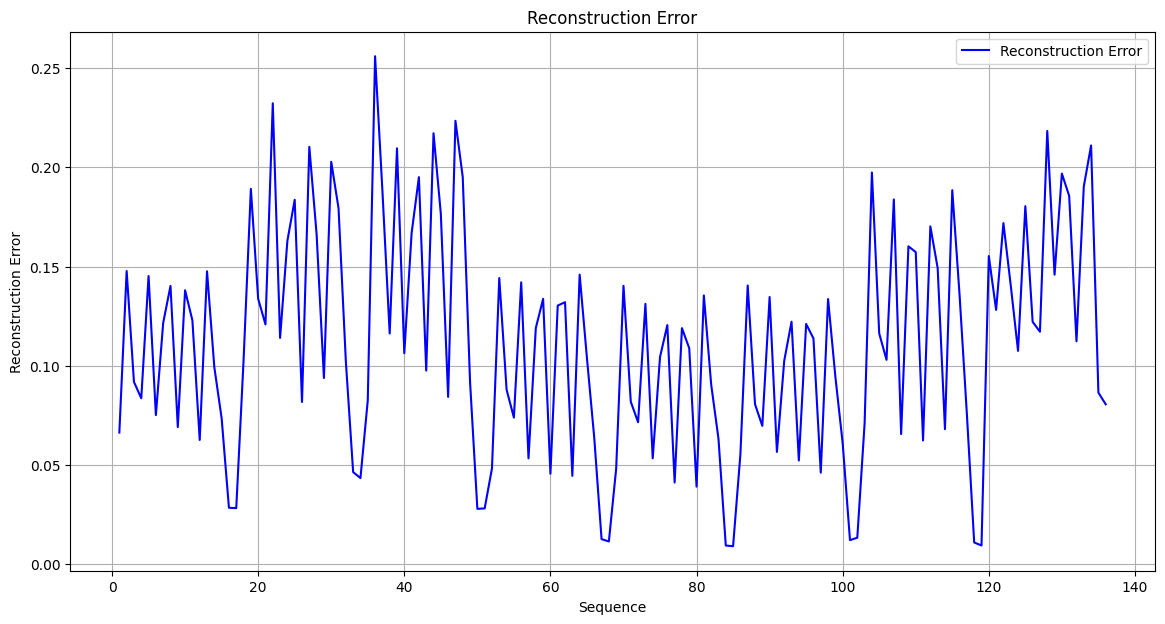

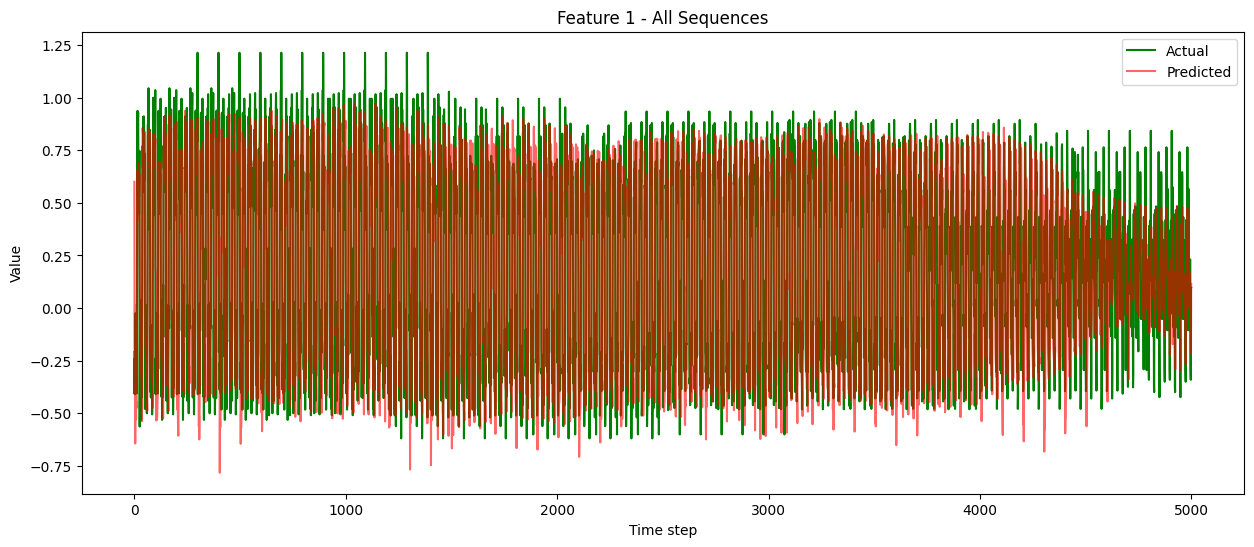

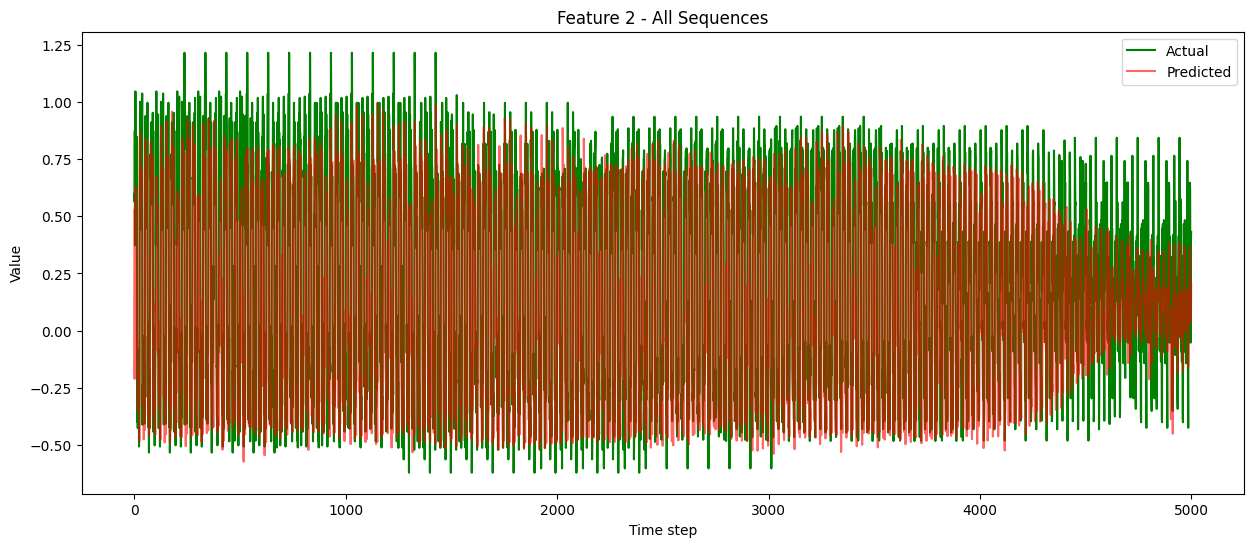

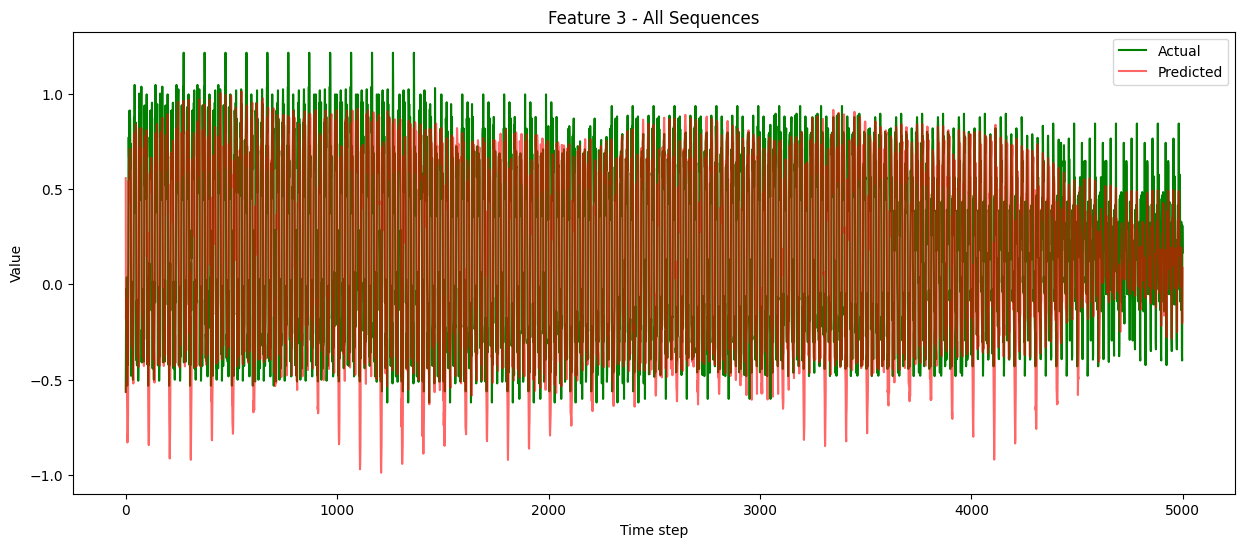

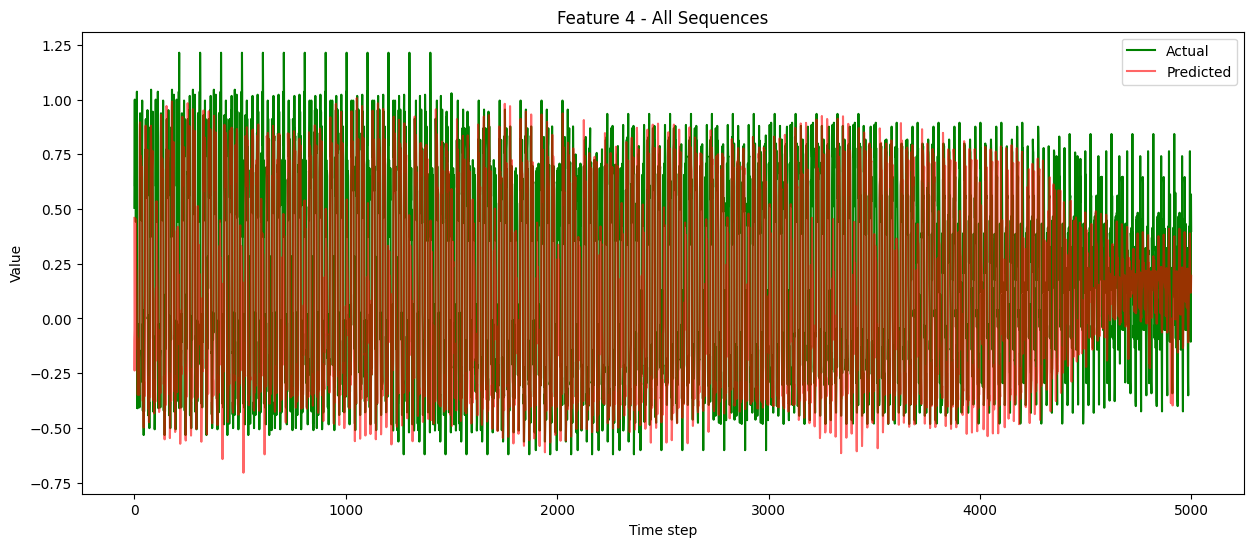

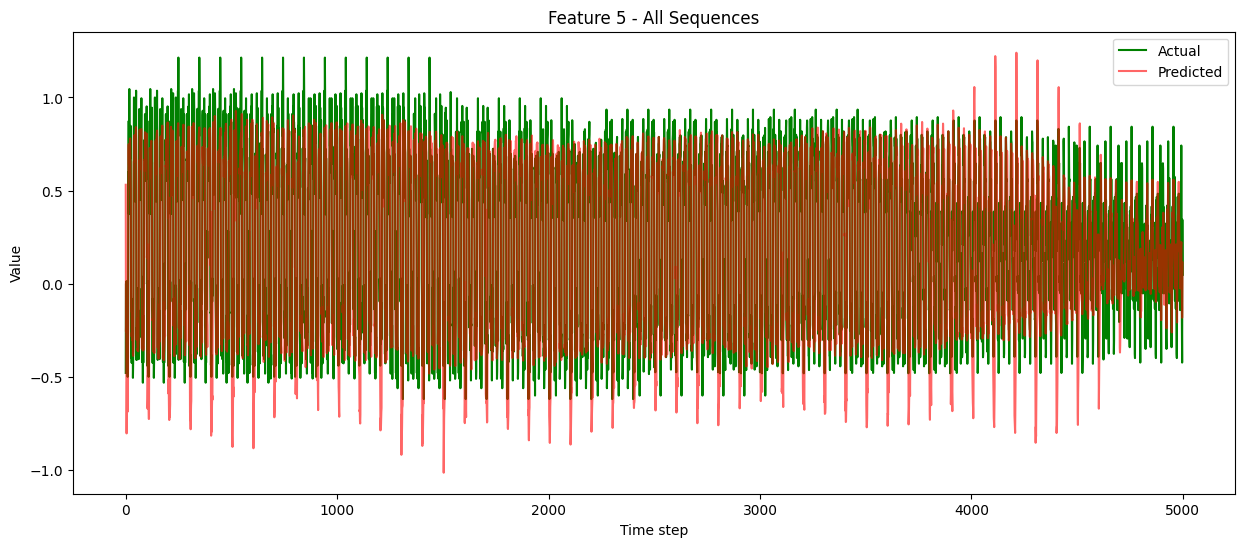

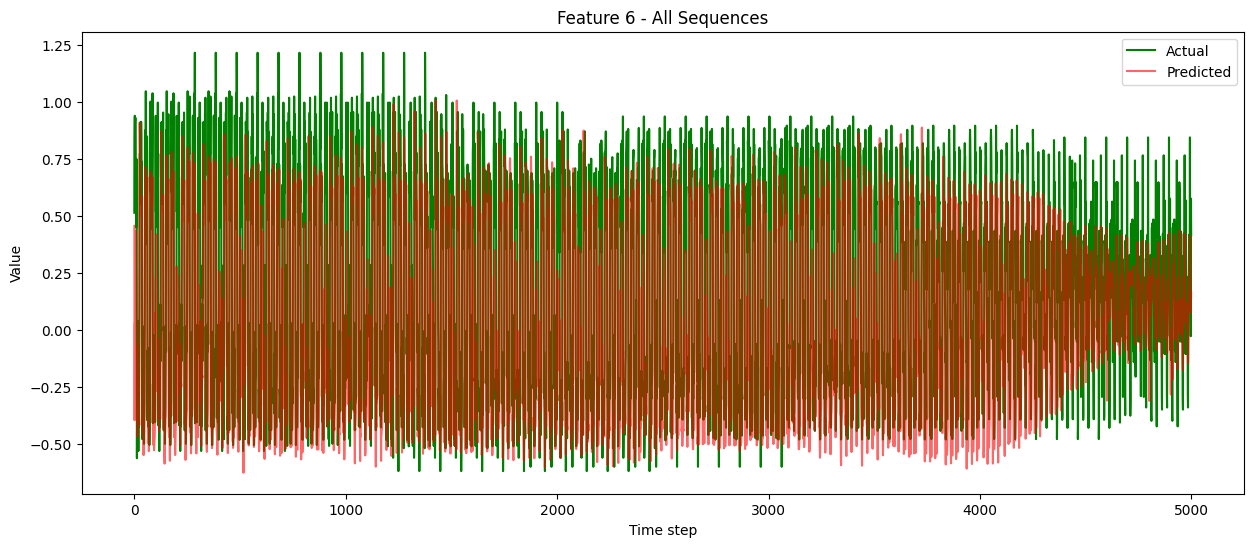

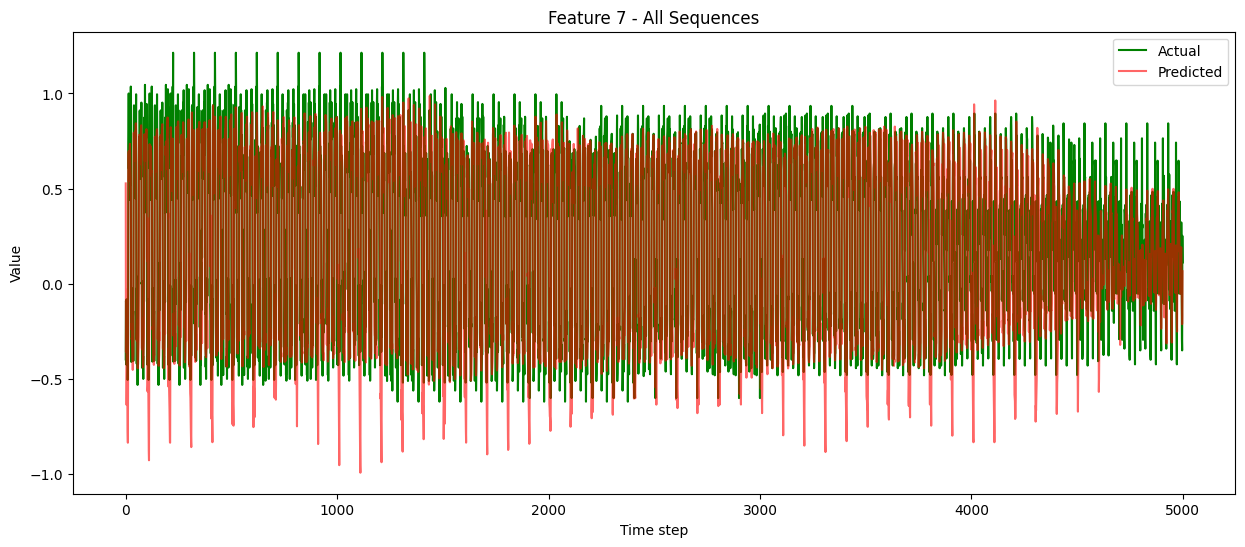

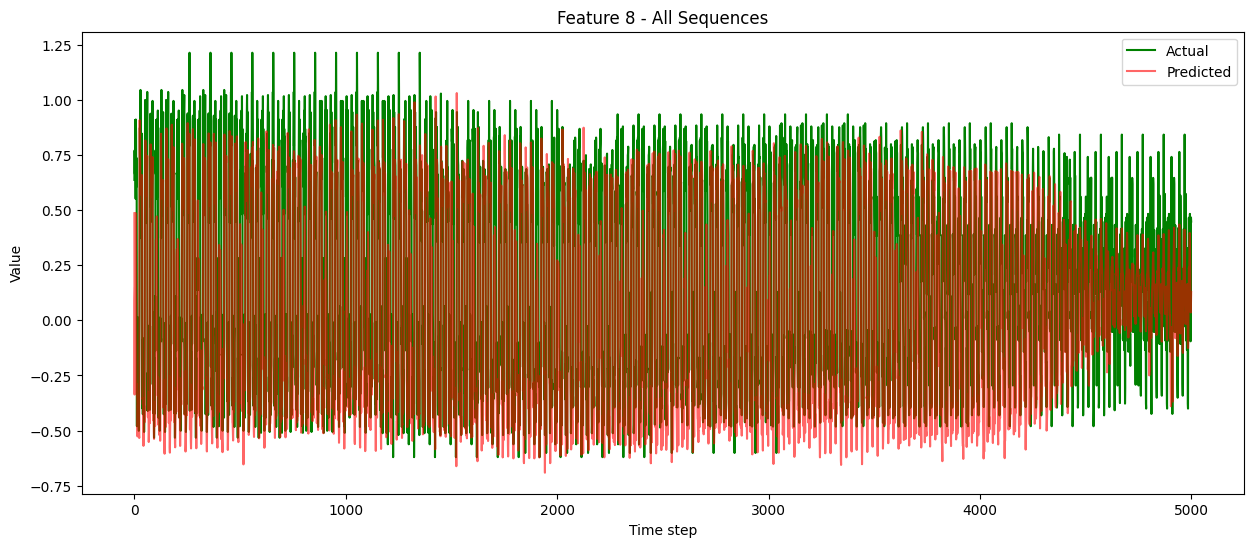

Threshhold: 0.20514063729941487


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMAutoencoder(device, seq_len=trainX.shape[1], n_features=trainX.shape[2]).to(device)

train(device, model, train_dl)

if supervised_mode:
    threshold = detect(model, test_dl, device, supervised_mode)
    print(f'Threshhold: {threshold}')
else:
    anomaly_score = detect(model, test_dl, device, supervised_mode)
    print(f'Anomalies Detected: {anomaly_score}')

In [6]:
torch.save(model.state_dict(), f"results/models/0_1_8.pth")